# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# Preparation

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

In [3]:
df = pd.read_csv("datasets/taxi.csv")

In [4]:
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


(None,
               datetime  num_orders
 0  2018-03-01 00:00:00           9
 1  2018-03-01 00:10:00          14
 2  2018-03-01 00:20:00          28
 3  2018-03-01 00:30:00          20
 4  2018-03-01 00:40:00          32)

In [5]:
# Convert datetime column to datetime format
df["datetime"] = pd.to_datetime(df["datetime"])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [7]:
# Resample the data by one hour and sum the orders
df_resampled = df.resample("1H", on="datetime").sum()

In [8]:
df_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Analysis

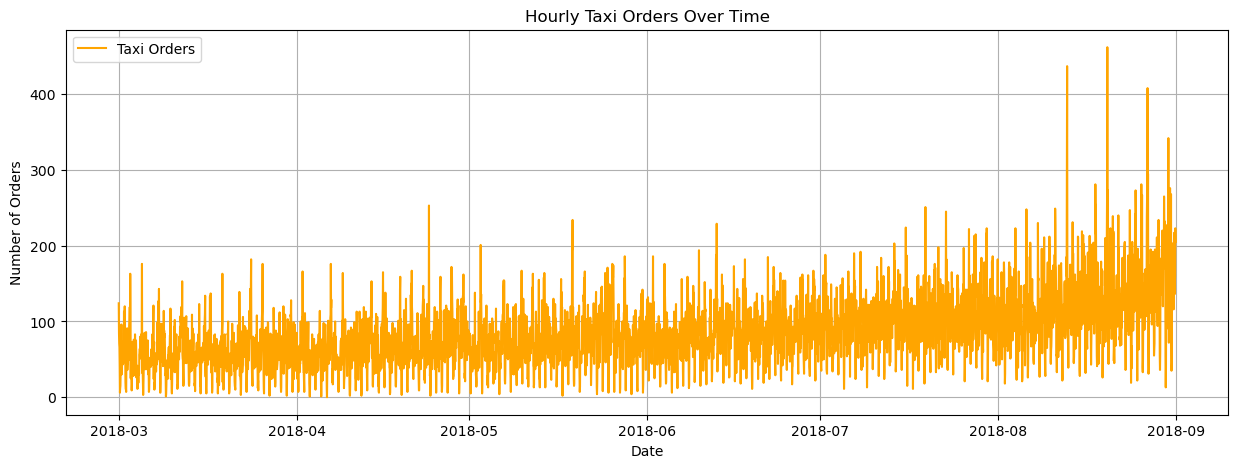

In [10]:
# Plot the time series data
plt.figure(figsize=(15, 5))
plt.plot(df_resampled.index, df_resampled["num_orders"], label="Taxi Orders", color="orange")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title("Hourly Taxi Orders Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Extract hour and day of the week
df_resampled["hour"] = df_resampled.index.hour
df_resampled["day_of_week"] = df_resampled.index.dayofweek

In [13]:
# Group by hour and compute average orders
hourly_avg = df_resampled.groupby("hour")["num_orders"].mean()

In [14]:
# Group by day of the week and compute average orders
daily_avg = df_resampled.groupby("day_of_week")["num_orders"].mean()

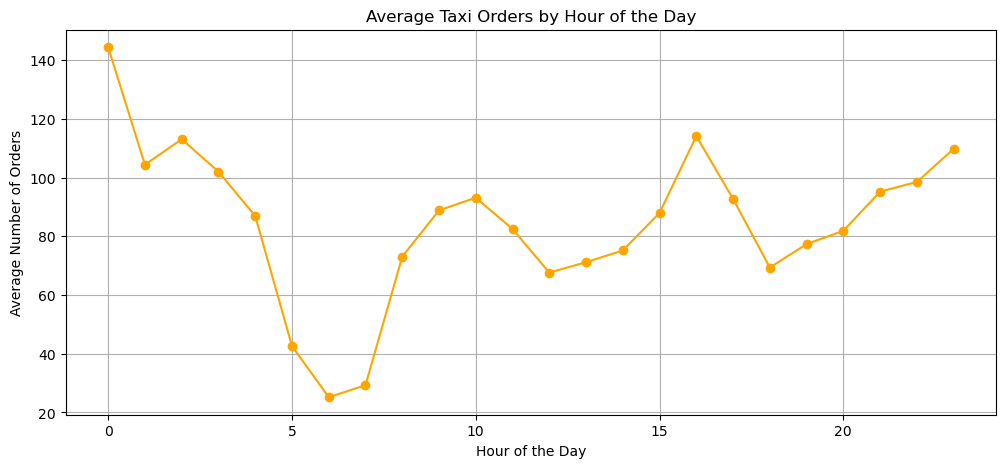

In [15]:
# Plot hourly pattern
plt.figure(figsize=(12, 5))
plt.plot(hourly_avg, marker='o', linestyle='-', color='orange')
plt.xlabel("Hour of the Day")
plt.ylabel("Average Number of Orders")
plt.title("Average Taxi Orders by Hour of the Day")
plt.grid(True)
plt.show()

The chart displays the average number of taxi orders by the hour of the day, revealing clear daily patterns in demand. Taxi orders peak just after midnight (00:00), likely due to late-night travelers and airport arrivals. After that, demand declines sharply until around 6 AM, when it reaches its lowest point.

Orders begin to rise again in the morning (7–10 AM), reflecting typical commuter and airport rush hours. A second, smaller peak occurs in the afternoon (around 5–6 PM), aligning with evening travel and workday endings. The number of orders then increases steadily through the evening, indicating higher demand at night.

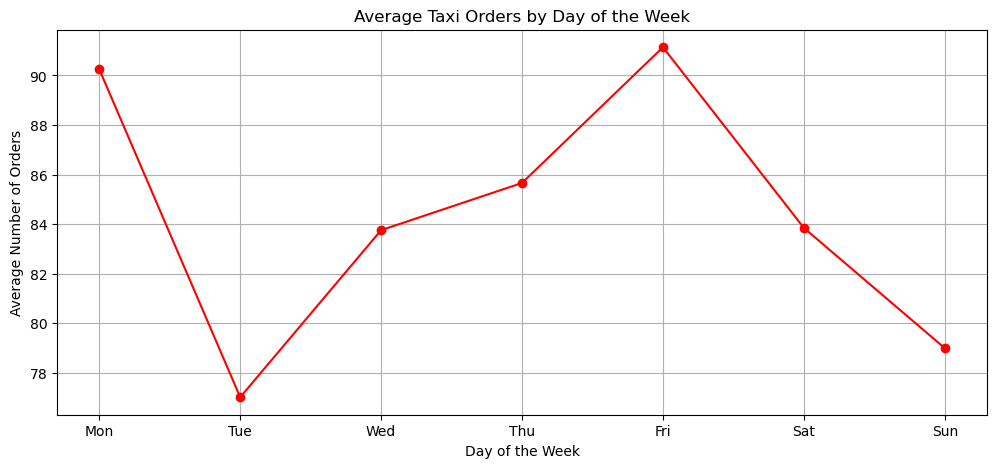

In [16]:
# Plot daily pattern
plt.figure(figsize=(12, 5))
plt.plot(daily_avg, marker='o', linestyle='-', color='red')
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.xlabel("Day of the Week")
plt.ylabel("Average Number of Orders")
plt.title("Average Taxi Orders by Day of the Week")
plt.grid(True)
plt.show()

This chart shows average taxi orders by day of the week, revealing clear weekly patterns in demand. The highest number of orders occurs on Fridays, likely due to increased travel and social activities before the weekend. Tuesdays have the lowest demand, which could be because it's a mid-week lull with fewer travelers.

Orders gradually increase from Tuesday through Friday, then drop over the weekend, with Sunday having the second-lowest demand. This suggests that weekdays, especially Mondays and Fridays, have higher taxi usage, while Tuesdays and Sundays see less demand.

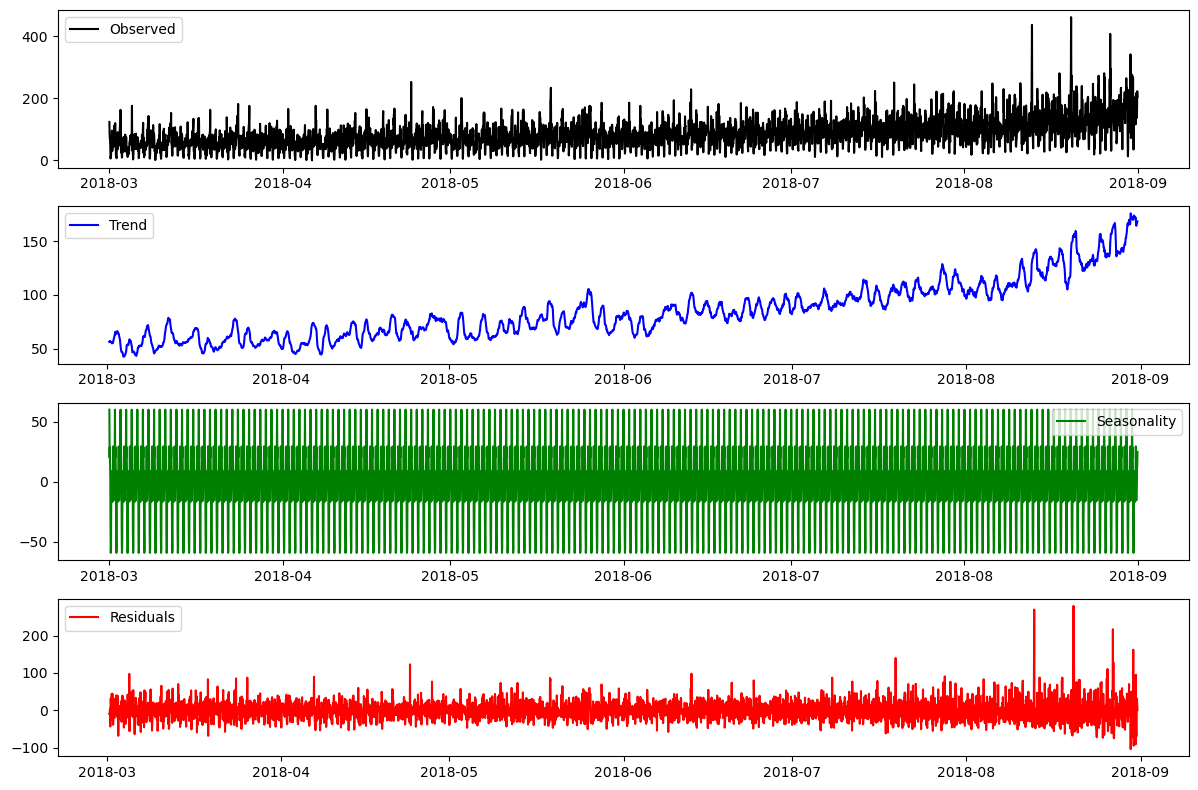

In [17]:
# Time series decomposition
decomposition = sm.tsa.seasonal_decompose(df_resampled["num_orders"], model="additive", period=24)

# Plot the decomposition results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label="Observed", color="black")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend", color="blue")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonality", color="green")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residuals", color="red")
plt.legend()

plt.tight_layout()
plt.show()

Observed Data (Top Panel): This represents the original time series data, showing fluctuations and an overall increasing trend in taxi demand over time. There are notable spikes, indicating possible high-demand events.

Trend Component (Second Panel): The trend reveals a steady increase in the number of taxi orders, suggesting a growing demand over the months. This could be due to seasonal changes, increased travel, or external factors such as airport activity fluctuations.

Seasonal Component (Third Panel): The seasonal pattern displays regular cycles of demand, confirming that taxi orders follow a consistent daily pattern. This aligns with previous findings, where certain hours (e.g., midnight, morning rush, and evening peak) have higher demand.

Residual Component (Bottom Panel): The residuals capture unexplained variations after removing trend and seasonality. There are noticeable spikes, suggesting periods of unexpected fluctuations, likely caused by special events, weather conditions, or anomalies in demand.

# Training

In [18]:
# Creating lag features (past orders to capture trends)
for lag in [1, 2, 3, 6, 12, 24]:  
    df_resampled[f"lag_{lag}"] = df_resampled["num_orders"].shift(lag)

In [19]:
# Creating rolling statistics to capture trends and variations
for window in [3, 6, 12]:  
    df_resampled[f"rolling_mean_{window}"] = df_resampled["num_orders"].shift(1).rolling(window=window).mean()
    df_resampled[f"rolling_std_{window}"] = df_resampled["num_orders"].shift(1).rolling(window=window).std()

In [20]:
# Drop NaN values from lag feature shifts
df_resampled.dropna(inplace=True)

In [21]:
# Define features and target
features = df_resampled.drop(columns=["num_orders"])
target = df_resampled["num_orders"]

In [22]:
# Train-test split (90% train, 10% test)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False, random_state=7)

In [23]:
# Confirm dataset shapes
features_train.shape, features_test.shape

((3952, 14), (440, 14))

# Testing

In [24]:
# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
target_pred_lr = lr_model.predict(features_test)
rmse_lr = np.sqrt(mean_squared_error(target_test, target_pred_lr))

In [25]:
# Train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=7)
rf_model.fit(features_train, target_train)
target_pred_rf = rf_model.predict(features_test)
rmse_rf = np.sqrt(mean_squared_error(target_test, target_pred_rf))

In [26]:
# Display RMSE results
rmse_lr, rmse_rf

(46.956286579482395, 44.03819835975045)

In [27]:
# Define Time Series Split
tscv = TimeSeriesSplit(n_splits=3)

In [28]:
# Define hyperparameter grid for tuning
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

In [29]:
# Perform Randomized Search Cross-Validation with TimeSeriesSplit
rf_tuned = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=15,
    cv=tscv,  
    scoring="neg_root_mean_squared_error",
    random_state=7,
    n_jobs=-1
)

In [30]:
# Fit the model
rf_tuned.fit(features_train, target_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=7, scoring='neg_root_mean_squared_error')

In [31]:
# Get best model predictions
target_pred_rf_tuned = rf_tuned.best_estimator_.predict(features_test)
rmse_rf_tuned = np.sqrt(mean_squared_error(target_test, target_pred_rf_tuned))

In [32]:
# Best parameters and updated RMSE
print("Best Random Forest Hyperparameters:", rf_tuned.best_params_)
print("Tuned Random Forest RMSE:", rmse_rf_tuned)

Best Random Forest Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True}
Tuned Random Forest RMSE: 42.979232808836066


In [33]:
# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(features_train, target_train)

# Predict with XGBoost
target_pred_xgb = xgb_model.predict(features_test)
rmse_xgb = np.sqrt(mean_squared_error(target_test, target_pred_xgb))

print("XGBoost RMSE:", rmse_xgb)

XGBoost RMSE: 45.89598221005442


In [34]:
# Train LightGBM Model
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(features_train, target_train)

# Predict with LightGBM
target_pred_lgb = lgb_model.predict(features_test)
rmse_lgb = np.sqrt(mean_squared_error(target_test, target_pred_lgb))

print("LightGBM RMSE:", rmse_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 14
[LightGBM] [Info] Start training from score 78.451417
LightGBM RMSE: 42.682314057959246


In [35]:
# Define hyperparameter grid for XGBoost tuning
xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0]
}

In [36]:
# Perform Randomized Search Cross-Validation with TimeSeriesSplit
xgb_tuned = RandomizedSearchCV(
    xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=15,
    cv=tscv,  
    scoring="neg_root_mean_squared_error",
    random_state=7,
    n_jobs=-1
)

In [37]:
# Fit the model
xgb_tuned.fit(features_train, target_train)

# Best model predictions
target_pred_xgb_tuned = xgb_tuned.best_estimator_.predict(features_test)
rmse_xgb_tuned = np.sqrt(mean_squared_error(target_test, target_pred_xgb_tuned))

In [38]:
# Displaying the best parameters and updated RMSE
print("Best XGBoost Hyperparameters:", xgb_tuned.best_params_)
print("Tuned XGBoost RMSE:", rmse_xgb_tuned)

Best XGBoost Hyperparameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Tuned XGBoost RMSE: 46.2107116986998


# Conclusion

Several regression models were evaluated based on their Root Mean Squared Error (RMSE) to determine predictive performance. The initial Linear Regression model achieved an RMSE of 46.96, while the baseline Random Forest model slightly outperformed it with an RMSE of 44.04. After hyperparameter tuning, the Random Forest model further improved to an RMSE of 42.98, showing the benefit of optimization. The XGBoost model initially recorded an RMSE of 45.90, which slightly worsened after tuning to 46.21, indicating that the tuning parameters may not have been ideal in this instance. Among all the models, LightGBM delivered the best performance, achieving the lowest RMSE of 42.68, suggesting it is the most accurate model for this dataset based on current results.